In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
from datetime import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,012 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [586 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,184 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,384 kB]
Hit:13 

In [3]:
# Import packages
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [4]:
from pyspark import SparkFiles
url = "https://nduffee-project4.s3.us-west-2.amazonaws.com/WalmartCleaned.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("WalmartCleaned.csv"), header= True, inferSchema= True)

# show the dataframe
df.show()

+---+-----+----------+------------+------------+-----------+----------+-----------+------------+---------------+
|_c0|Store|      Date|Weekly_Sales|Holiday_Flag|Temperature|Fuel_Price|        CPI|Unemployment|   Holiday_Name|
+---+-----+----------+------------+------------+-----------+----------+-----------+------------+---------------+
|  0|    1|2010-02-05|   1643690.9|           1|      42.31|     2.572|211.0963582|       8.106|     Super Bowl|
|  1|    1|2010-02-12|  1641957.44|           1|      38.51|     2.548|211.2421698|       8.106|Valentine's Day|
|  2|    1|2010-02-19|  1611968.17|           0|      39.93|     2.514|211.2891429|       8.106|           NULL|
|  3|    1|2010-02-26|  1409727.59|           0|      46.63|     2.561|211.3196429|       8.106|           NULL|
|  4|    1|2010-03-05|  1554806.68|           0|       46.5|     2.625|211.3501429|       8.106|           NULL|
|  5|    1|2010-03-12|  1439541.59|           0|      57.79|     2.667|211.3806429|       8.106|

In [5]:
# Convert to pandas Dataframe
store_data = df.toPandas()
store_data.head()

,_c0,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Name
0,0,1,2010-02-05,1643690.90,1,42.31,2.572,211.096358,8.106,Super Bowl
1,1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,Valentine's Day
2,2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,None
3,3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,None
4,4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,None


In [6]:
##EXPLORE DATA##

In [7]:
# Split date column into day, month, year
store_data["Day"]=pd.DatetimeIndex(store_data['Date']).day
store_data["Month"]=pd.DatetimeIndex(store_data['Date']).month
store_data["Year"]=pd.DatetimeIndex(store_data['Date']).year
store_data

,_c0,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Name,Day,Month,Year
0,0,1,2010-02-05,1643690.90,1,42.31,2.572,211.096358,8.106,Super Bowl,5,2,2010
1,1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,Valentine's Day,12,2,2010
2,2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,None,19,2,2010
3,3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,None,26,2,2010
4,4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,None,5,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,None,28,9,2012
6431,6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,None,5,10,2012
6432,6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,None,12,10,2012
6433,6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,None,19,10,2012


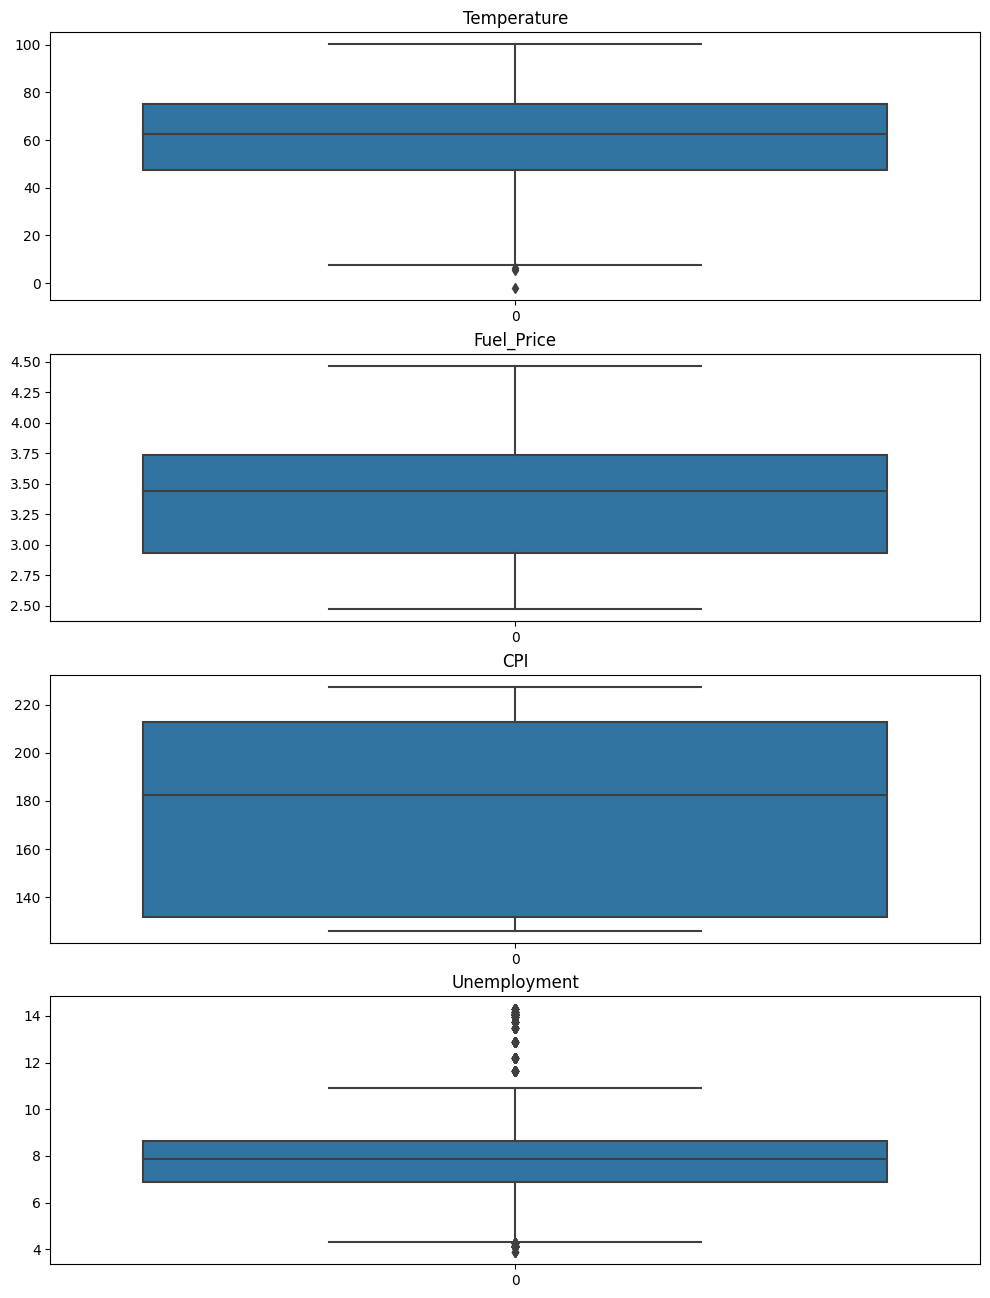

In [8]:
#Detecting outliers with boxplot
fig, axis = plt.subplots(4,figsize=(12,16))
columns_to_display=['Temperature','Fuel_Price','CPI','Unemployment']
X = store_data[columns_to_display]

for i,column in enumerate(X):
    sns.boxplot(store_data[column],ax=axis[i]).set_title(columns_to_display[i])

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Remove outliers
store_data_clean = store_data[(store_data['Unemployment']<=10) & (store_data['Unemployment']>=4.5) & (store_data['Temperature']>=10)]
store_data_clean

,_c0,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Name,Day,Month,Year
0,0,1,2010-02-05,1643690.90,1,42.31,2.572,211.096358,8.106,Super Bowl,5,2,2010
1,1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,Valentine's Day,12,2,2010
2,2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,None,19,2,2010
3,3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,None,26,2,2010
4,4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,None,5,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,None,28,9,2012
6431,6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,None,5,10,2012
6432,6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,None,12,10,2012
6433,6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,None,19,10,2012


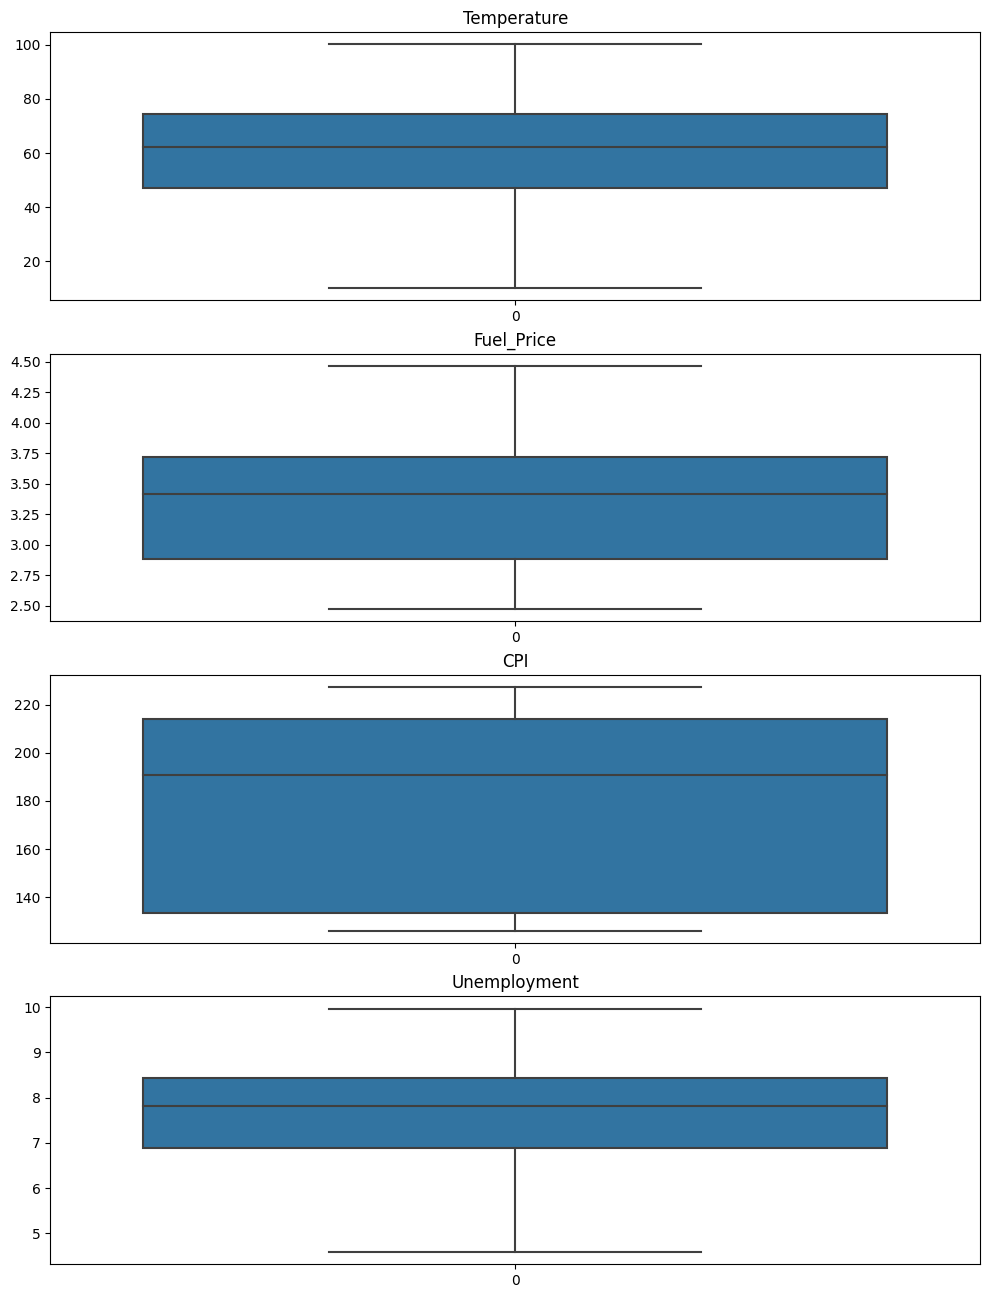

In [10]:
#Checking if outliers were removed
fig, axis = plt.subplots(4,figsize=(12,16))
columns_to_display=['Temperature','Fuel_Price','CPI','Unemployment']
X = store_data_clean[columns_to_display]

for i,column in enumerate(X):
    sns.boxplot(store_data_clean[column],ax=axis[i]).set_title(columns_to_display[i])

import warnings
warnings.filterwarnings('ignore')

In [11]:
# Seperate the features, X, from the target variable, y
y = store_data_clean['Weekly_Sales']
X = store_data_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]

In [12]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:
# Predict target variable and evaluate the model
y_pred=model.predict(X_test)

print('Linear Regression Model:')
print('Accuracy:',model.score(X_train,y_train)*100)
print('Mean Squared Error:',metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,y_pred))

Linear Regression Model:
Accuracy: 12.581194141014418
Mean Squared Error: 283735911131.3446
Root Mean Squared Error: 532668.6691850241
Mean Absolute Error: 443062.6607305411


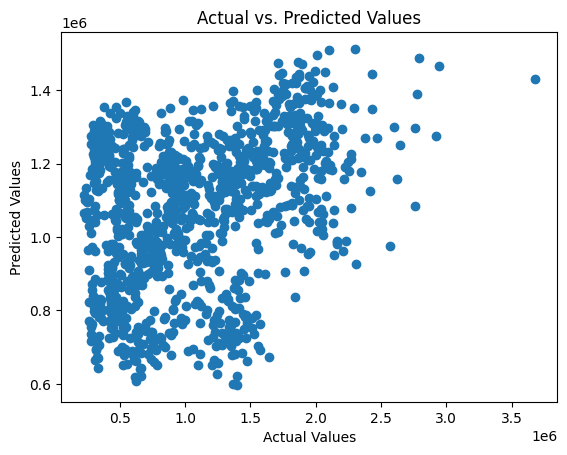

In [15]:
# Visualize the model's prediction
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

As we can see from the evaluation of the Linear Regression model and the resulting graph of it's predicted vs actual values, this is not an ideal model for our dataset. The accuracy is less than 13%.

In [16]:
# Random Forest Regressor (regressor is between suited for numeric values than classifier)
# Create and train Model
rf=RandomForestRegressor()

rf.fit(X_train,y_train)

RandomForestRegressor()

In [17]:
# Predict target variable and evaluate the model
y_pred=rf.predict(X_test)

print('Random Forest Regressor:')
print('Accuracy:',rf.score(X_test, y_test)*100)
print('r2:',r2_score(y_test,y_pred))
print('Mean Squared Error:',metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,y_pred))

Random Forest Regressor:
Accuracy: 96.7083230103115
r2: 0.967083230103115
Mean Squared Error: 10908444011.021915
Root Mean Squared Error: 104443.49673877218
Mean Absolute Error: 56437.0733144876


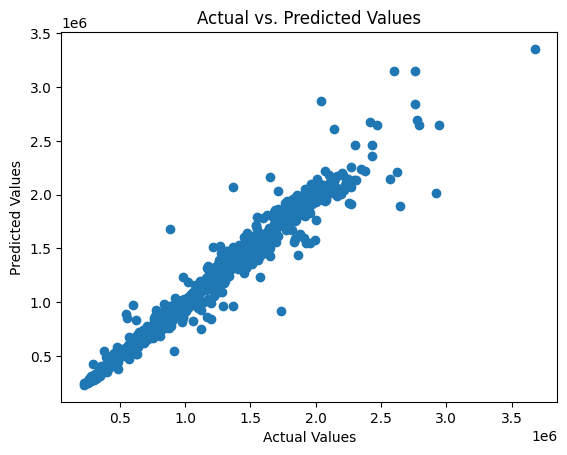

In [18]:
# Visualize the model's prediction
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

After running the dataset through the Random Forest Regressor model, we can see it is much better suited to predict demand with accuracy of almost 97%.